<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#전체-시계열로-예측" data-toc-modified-id="전체-시계열로-예측-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>전체 시계열로 예측</a></span><ul class="toc-item"><li><span><a href="#Prophet-라이브러리-사용" data-toc-modified-id="Prophet-라이브러리-사용-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prophet 라이브러리 사용</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#날짜와-Y값으로만-예측" data-toc-modified-id="날짜와-Y값으로만-예측-1.1.0.1"><span class="toc-item-num">1.1.0.1&nbsp;&nbsp;</span>날짜와 Y값으로만 예측</a></span></li></ul></li><li><span><a href="#요일별-데이터로-예측" data-toc-modified-id="요일별-데이터로-예측-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>요일별 데이터로 예측</a></span></li></ul></li><li><span><a href="#ARIMA-사용하기" data-toc-modified-id="ARIMA-사용하기-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>ARIMA 사용하기</a></span><ul class="toc-item"><li><span><a href="#전체-시계열-데이터-정상성-체크" data-toc-modified-id="전체-시계열-데이터-정상성-체크-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>전체 시계열 데이터 정상성 체크</a></span></li><li><span><a href="#요일별-데이터-정상성-체크" data-toc-modified-id="요일별-데이터-정상성-체크-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>요일별 데이터 정상성 체크</a></span></li><li><span><a href="#Auto-ARIMA로-적합-및-예측" data-toc-modified-id="Auto-ARIMA로-적합-및-예측-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Auto ARIMA로 적합 및 예측</a></span></li></ul></li><li><span><a href="#머신러닝-모델" data-toc-modified-id="머신러닝-모델-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>머신러닝 모델</a></span><ul class="toc-item"><li><span><a href="#기본적인-데이터-전처리" data-toc-modified-id="기본적인-데이터-전처리-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>기본적인 데이터 전처리</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Polynomial-Linear-Regression" data-toc-modified-id="Polynomial-Linear-Regression-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Polynomial Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#XGBoost-Regressor" data-toc-modified-id="XGBoost-Regressor-1.3.6"><span class="toc-item-num">1.3.6&nbsp;&nbsp;</span>XGBoost Regressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-1.3.7"><span class="toc-item-num">1.3.7&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Hybrid-Voting" data-toc-modified-id="Hybrid-Voting-1.3.8"><span class="toc-item-num">1.3.8&nbsp;&nbsp;</span>Hybrid Voting</a></span></li><li><span><a href="#MLP-Regressor" data-toc-modified-id="MLP-Regressor-1.3.9"><span class="toc-item-num">1.3.9&nbsp;&nbsp;</span>MLP Regressor</a></span></li><li><span><a href="#PLS-Regression" data-toc-modified-id="PLS-Regression-1.3.10"><span class="toc-item-num">1.3.10&nbsp;&nbsp;</span>PLS Regression</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1.3.11"><span class="toc-item-num">1.3.11&nbsp;&nbsp;</span>Feature Engineering</a></span></li></ul></li></ul></li></ul></div>

 데이터 생성

- 전체 시계열로 예측
    * 요일에 가중치 파생변수 두기
    * 모델 종류
        - Prophet : 결측치 제거하지 않아도 됨
        - ARIMA : 매출액에 대한 정상성 확보
        - 머신러닝 회귀모델
        - 딥러닝 RNN 모델
- 요일 시계열로 예측
    * 요일별로 데이터프레임 나누기
    * 요일별로 모델 생성

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')
os.chdir('/Users/younghun/Desktop/gitrepo/data/woochuri/')

In [2]:
df = pd.read_csv('./woochuri_final_data.csv')

# 전체 시계열로 예측
## Prophet 라이브러리 사용
- 결측치 제거하지 않아도 됨
- 원래는 날짜, Y값 변수만 넣지만 독립변수 추가는 가능함. 하지만 추가하면 미래의 Y값을 예측하기 위해 직전의 Y값을 쓰는 것이 아닌 추가된 독립변수만을 사용..

#### 날짜와 Y값으로만 예측

In [3]:
from fbprophet import Prophet

In [4]:
fb_df = df[['날짜', '일매출']]
# 일매출이 0인 값은 결측치로 다시 바꾸기
fb_df['일매출'] = fb_df['일매출'].replace(0, np.nan)
fb_df.isnull().sum()

날짜      0
일매출    86
dtype: int64

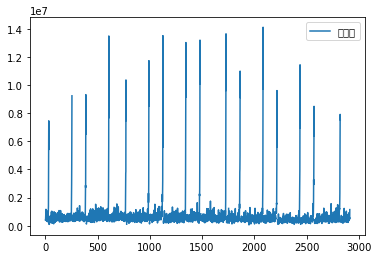

In [5]:
# 간단하게 시각화해보기
from matplotlib import pyplot
fb_df.plot()
pyplot.rc('font', family='AppleGothic')
pyplot.rcParams['axes.unicode_minus'] = False
pyplot.show()

In [6]:
# Split train, test data
splits = int(fb_df.shape[0] * 0.8)
train_df = fb_df.iloc[0: splits]
test_df = fb_df.iloc[splits:]
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (2332, 2)
Test shape: (583, 2)


In [7]:
# 칼럼명 날짜는 'ds'로 일매출은 'y'로 바꾸자
train_df.columns = ['ds', 'y']
test_df.columns = ['ds', 'y']
# 'ds' datetime type으로 바꾸기
train_df['ds'] = pd.to_datetime(train_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

In [8]:
# 모델 정의
model = Prophet()
# Train데이터로 학습
model.fit(train_df)

# Test데이터의 'ds'로 모델 평가
forecast = model.predict(test_df[['ds']])
test_df['y_pred'] = forecast['yhat'].values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
from sklearn.metrics import mean_absolute_error
test = test_df.dropna()
mae = mean_absolute_error(test['y'], test['y_pred'])
print("MAE:", mae)

MAE: 389379.4545916285


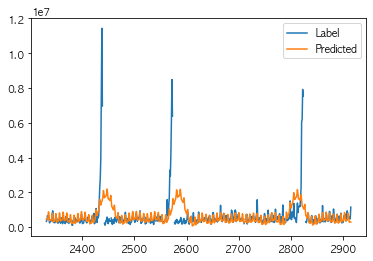

In [10]:
pyplot.plot(test_df['y'], label='Label')
pyplot.plot(test_df['y_pred'], label='Predicted')
pyplot.legend()
pyplot.show()

- 아무리 Holiday 요소를 고려한다 해도 추석, 설날 주변의 특이 이상치를 예측하지 못한다..

In [11]:
# 이상치를 제거하고 예측해보자
out_fb_df = df.loc[df['설_추석_가중치'] == 0, ['날짜', '일매출']]
splits = int(fb_df.shape[0] * 0.8)
train_df = out_fb_df.iloc[:splits]
test_df = out_fb_df.iloc[splits:]

train_df.columns = ['ds', 'y']
test_df.columns = ['ds', 'y']
train_df['ds'] = pd.to_datetime(train_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

In [12]:
# 모델 정의, 학습
model = Prophet()
model.fit(train_df)

# Test 데이터에 대해 모델 예측
forecast = model.predict(test_df[['ds']])
test_df['y_pred'] = forecast['yhat'].values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
test = test_df.dropna()
mae = mean_absolute_error(test['y'], test['y_pred'])
print("MAE:", mae)

MAE: 254080.33156528362


### 요일별 데이터로 예측

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Friday의 MAE: 433185.66


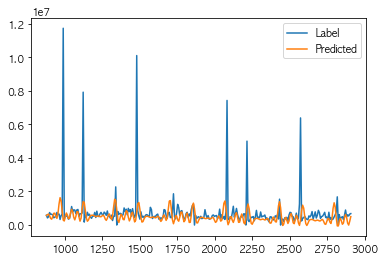

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Monday의 MAE: 352026.29


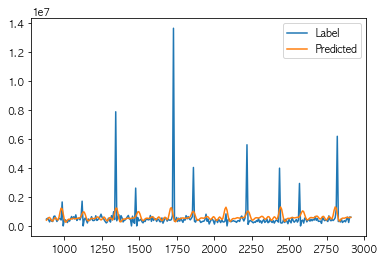

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Saturday의 MAE: 794679.53


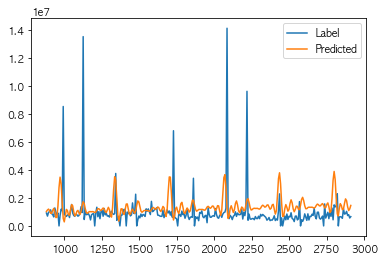

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Sunday의 MAE: 965775.53


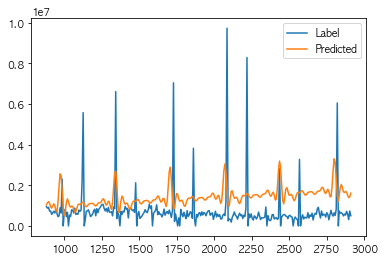

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Thursday의 MAE: 359964.51


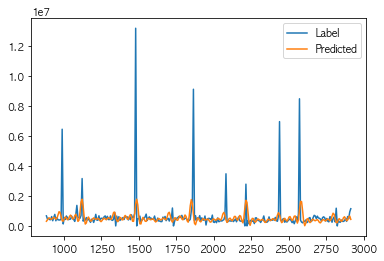

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Tuesday의 MAE: 622067.25


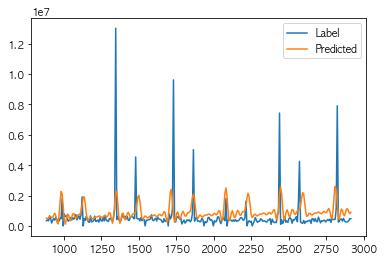

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Wednesday의 MAE: 423828.94


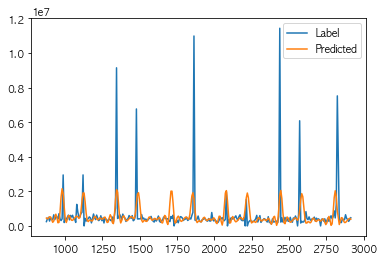

--------------------------------------------------


In [14]:
import math
fb_df = df[['날짜', '일매출', '요일']]
grouped = fb_df.groupby('요일')
weekday_lst = list(grouped.groups.keys())
for i, g in enumerate(grouped.groups):
    group = grouped.get_group(g)
    group = group[['날짜', '일매출']]
    group.columns = ['ds', 'y']

    splits = math.ceil(group.shape[0] * 0.3)
    train_df = group.iloc[:splits]
    test_df = group.iloc[splits:]
    # 모델 정의
    model = Prophet()
    model.fit(train_df)
    # 모델 평가
    forecast = model.predict(test_df[['ds']])
    test_df['y_pred'] = forecast['yhat'].values
    # 모델 성능 측정
    mae = mean_absolute_error(test_df['y'], test_df['y_pred'])
    print(f"{weekday_lst[i]}의 MAE: {mae :.2f}")
    pyplot.plot(test_df['y'], label='Label')
    pyplot.plot(test_df['y_pred'], label='Predicted')
    pyplot.legend()
    pyplot.show()
    print('-'*50)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Friday의 MAE: 223465.77


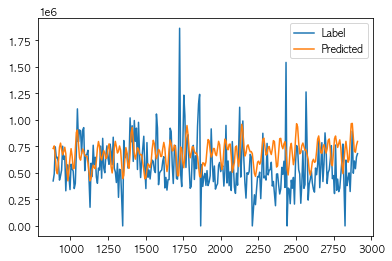

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Monday의 MAE: 274909.42


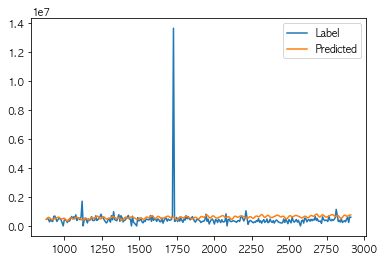

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Saturday의 MAE: 371460.66


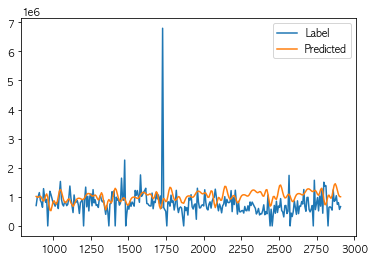

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Sunday의 MAE: 390815.21


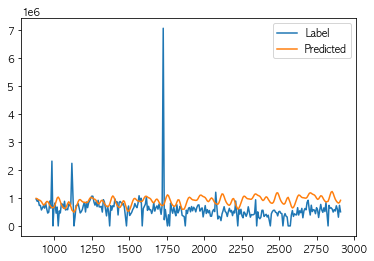

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Thursday의 MAE: 233623.97


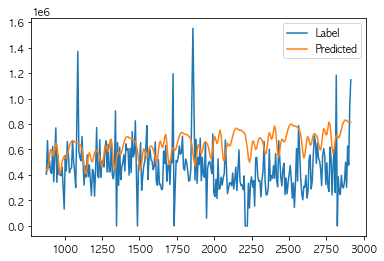

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Tuesday의 MAE: 287527.86


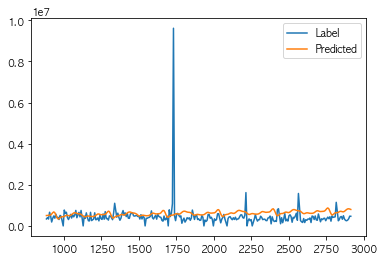

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Wednesday의 MAE: 149924.24


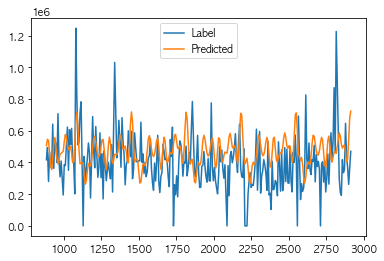

--------------------------------------------------


In [15]:
# 이상치 데이터를 제거하고 재시도
import math
fb_df = df.loc[df['설_추석_가중치'] == 0, ['날짜', '일매출', '요일']]
grouped = fb_df.groupby('요일')
weekday_lst = list(grouped.groups.keys())
for i, g in enumerate(grouped.groups):
    group = grouped.get_group(g)
    group = group[['날짜', '일매출']]
    group.columns = ['ds', 'y']

    splits = math.ceil(group.shape[0] * 0.3)
    train_df = group.iloc[:splits]
    test_df = group.iloc[splits:]
    # 모델 정의
    model = Prophet()
    model.fit(train_df)
    # 모델 평가
    forecast = model.predict(test_df[['ds']])
    test_df['y_pred'] = forecast['yhat'].values
    # 모델 성능 측정
    mae = mean_absolute_error(test_df['y'], test_df['y_pred'])
    print(f"{weekday_lst[i]}의 MAE: {mae :.2f}")
    pyplot.plot(test_df['y'], label='Label')
    pyplot.plot(test_df['y_pred'], label='Predicted')
    pyplot.legend()
    pyplot.show()
    print('-'*50)

- 전체 시계열보다 요일별 모델이 더 에러값이 적다
- 추석_설_가중치가 있는 값들 즉, 설,추석 연휴 매출이 높은 값들을 제거하는 것이 오히려 더 정확했다..하지만 이렇게 하면 미래에 맞이할 설,추석 연휴 매출을 예측하기가 어려워짐..

In [16]:
# 어떻게 개선해야 할까.. 생각좀해보자...
# Prophet을 더 개선해야 하는지
# ARIMA는 보나마나 못맞출 것 같고..
# 머신러닝, 딥러닝을 사용해야 하나..
# 데이터가 적다보니 앙상블 모델을 하는 것도 좋을 듯 하다..

## ARIMA 사용하기
- 우선 일매출값의 정상성 확보
- 결측치 없애야 함 => 일매출값이 0인 값들 제외
- AR, MA 차수 범위 확인 후 Auto Arima 적용

### 전체 시계열 데이터 정상성 체크

In [17]:
# 일매출이 0인 값들 제외
print("제거하기 전 shape:", df.shape)
df = df[df['일매출'] != 0]

print("제거한 후 shape:", df.shape)

제거하기 전 shape: (2915, 18)
제거한 후 shape: (2829, 18)


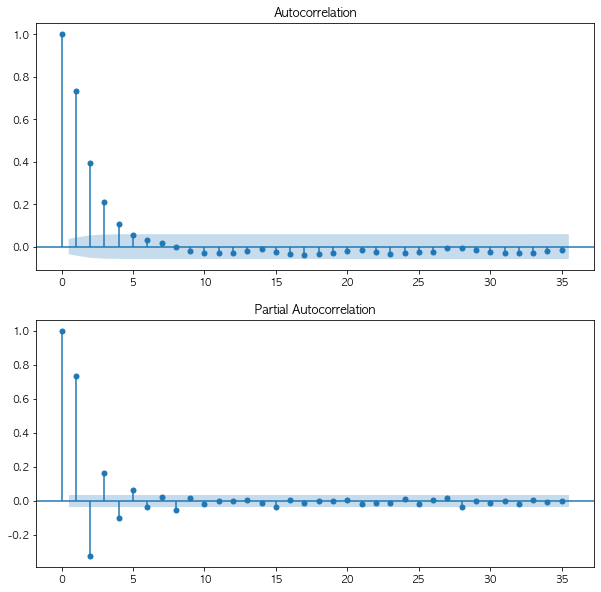

In [18]:
# ACF, PACF 그래프 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=1, squeeze=True)
plot_acf(df['일매출'], ax=axes[0])
plot_pacf(df['일매출'], ax=axes[1])
plt.show()

- 일반 AR,MA 차수 체크
    - ACF 함수 그래프에서 파란색 부분을 튀어나온 개수만큼 MA 수행
        * 0번 ~ 3번 또는 4번
    - PACF 함수 그래프에서 파란색 부분을 튀어나온 개수만큼 AR 수행
        * 0번 ~ 3번 또는 4번
<br><br>
- 계절성 AR,MA 차수 체크(lag=4의 배수일 때의 막대를 확인!)
    - ACF 함수 그래프에서 lag=4일 때 튀어나온 막대 개수만큼 MA 수행
        * 0번 ~ 1번
    - PACF 함수 그래프에서 lag=4일 때 튀어나온 막대 개수만큼 AR 수행
        * 0번 ~ 1번


In [19]:
# 해당 시계열 데이터의 정상성 통계적 검정하기
# 1. KPSS 검정 - 귀무가설 : 해당 시계열 데이터는 정상성이다.
from statsmodels.tsa.stattools import kpss
stats, p_value, n_lags, c_values = kpss(df['일매출'])

print("KPSS 검정통계량:", stats)
print("P-value:", p_value)

if p_value < 0.05:
    print("귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!")
else:
    print("귀무가설을 채택! 즉, 해당 데이터는 정상성이다!")

KPSS 검정통계량: 0.1493985081951096
P-value: 0.1
귀무가설을 채택! 즉, 해당 데이터는 정상성이다!


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [20]:
# ADFuller Test도 수행 - 귀무가설 : 해당 시계열 데이터는 비정상성이다.
from statsmodels.tsa.stattools import adfuller

res = adfuller(df['일매출'])
print("ADFuller 검정통계량:", res[0])
print("P-value:", res[1])

if res[1] < 0.05:
    print("귀무가설을 기각! 즉, 해당 데이터는 정상성이다!")
else:
    print("귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!")

ADFuller 검정통계량: -16.731526931101694
P-value: 1.3818258984652357e-29
귀무가설을 기각! 즉, 해당 데이터는 정상성이다!


- **일매출 전체 시계열 데이터는 정상성이다!**

### 요일별 데이터 정상성 체크

In [21]:
# KPSS, ADFuller 둘다 테스트하는 함수 정의
def check_stationary(df):
    # test
    kpss_res = kpss(df['일매출'])
    adf_res = adfuller(df['일매출'])
    
    # KPSS
    if kpss_res[1] < 0.05:
        print("KPSS - 귀무가설을 기각! 즉, 해당 데이터는 정상성이다!")
    else:
        print("KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!")
    
    # ADFuller
    if adf_res[1] < 0.05:
        print("ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!")
    else:
        print("ADFuller - 귀무가설을 채택! 즉, 해당 데이터는 정상성이다!")    

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


# Friday 일매출 데이터 정상성 체크
KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!
ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!


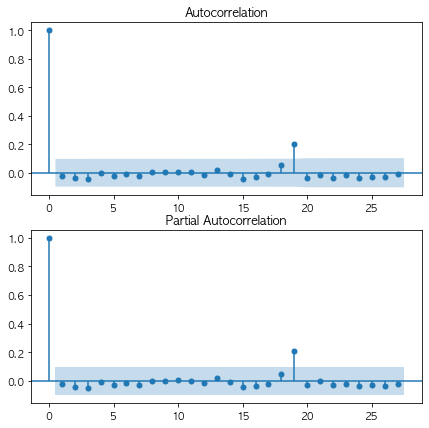

--------------------------------------------------
# Monday 일매출 데이터 정상성 체크
KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!
ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


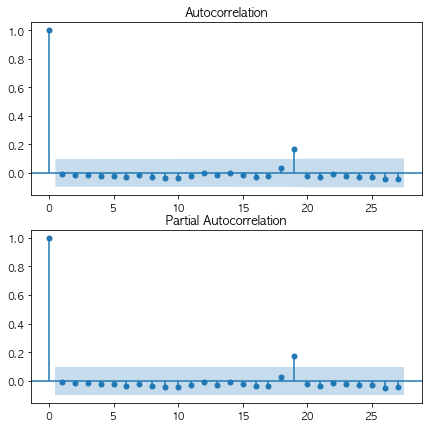

--------------------------------------------------
# Saturday 일매출 데이터 정상성 체크
KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!
ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


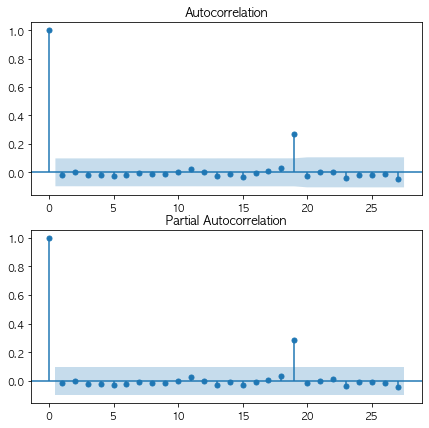

--------------------------------------------------
# Sunday 일매출 데이터 정상성 체크
KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!
ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!


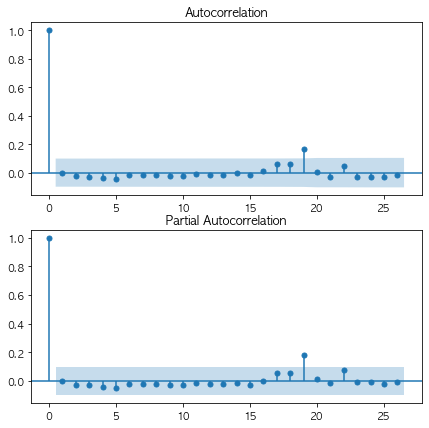

--------------------------------------------------
# Thursday 일매출 데이터 정상성 체크
KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!
ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


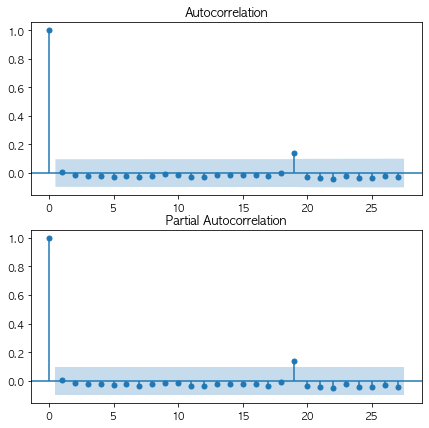

--------------------------------------------------
# Tuesday 일매출 데이터 정상성 체크
KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!
ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


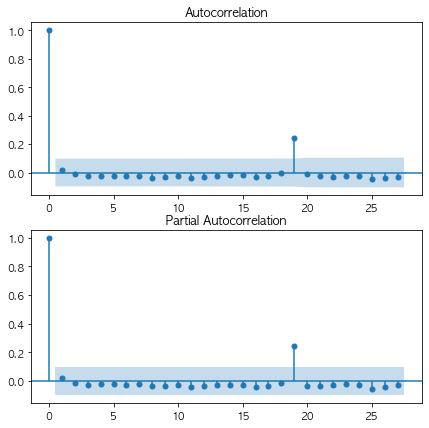

--------------------------------------------------
# Wednesday 일매출 데이터 정상성 체크
KPSS - 귀무가설을 채택! 즉, 해당 데이터는 비정상성이다!
ADFuller - 귀무가설을 기각! 즉, 해당 데이터는 비정상성이다!


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


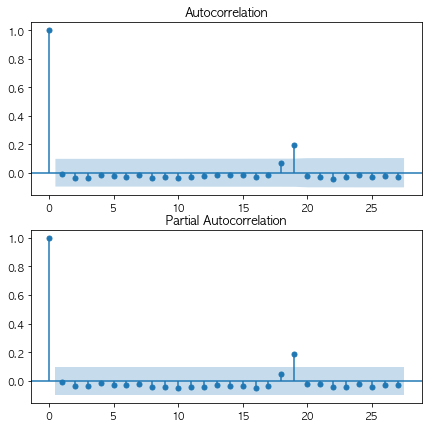

--------------------------------------------------


In [22]:
# 요일별 일매출 데이터 정상성 체크하고 ACF, PACF 함수 관찰후 대략적인 AR, MA 차수 결정하기
grouped = df.groupby('요일')
weekday_lst = list(grouped.groups.keys())

for i, g in enumerate(grouped.groups):
    group_df = grouped.get_group(g)
    print(f"# {weekday_lst[i]} 일매출 데이터 정상성 체크")
    check_stationary(group_df)
    fig, axes = plt.subplots(figsize=(7, 7), nrows=2, ncols=1, squeeze=True)
    plot_acf(group_df['일매출'], ax=axes[0])
    plot_pacf(group_df['일매출'], ax=axes[1])
    plt.show()
    print('-'*50)

- **요일별 일매출 데이터는 모든 요일에 대해 전부 데이터가 비정상성이다!**
- 따라서, ARIMA 모델링 시 **차분** 필요!
- 또한 요일별 ACF, PACF 그래프 관찰한 결과 모든 요일별 데이터에 대해 다음과 같은 AR, MA 차수 범위 얻음
    * AR : 0~1번
    * MA : 0~1번
- 참고로, 계절성 AR, MA 차수는 0번으로 해도 되는 것으로 관찰!

### Auto ARIMA로 적합 및 예측

In [23]:
from pmdarima.arima import auto_arima
import math

# split train, test data
splits = math.ceil(df.shape[0] * 0.8)
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.set_index('날짜')

train = df['일매출'][:splits]
test = df['일매출'][splits:]
print("Train:", train.shape)
print("Test:", test.shape)

Train: (2264,)
Test: (565,)


In [24]:
# p = AR, q = MA, d = 차분
# 대문자 P,D,Q 파라미터는 계절적 요소알아보는 것!
# m = 계절 차분에 대한 periods 설정인데, daily=7로 설정!
arima_model = auto_arima(train, start_p=0, d=0, start_q=0,
                        max_p=4, max_d=1, max_q=4,
                        start_P=0, D=0, start_Q=0,
                        max_P=1, max_D=5, max_Q=1,
                        m=7, seasonal=True,
                        error_action='warn', trace=True,
                        stepwise=True, random_state=42)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=69713.872, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=68020.593, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=68165.733, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=70472.143, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=68019.425, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=68020.598, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=68022.586, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=67768.781, Time=0.12 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=67768.636, Time=0.37 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=67770.537, Time=0.58 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=67768.551, Time=0.26 sec
 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=67708.048, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=67706.810, Time=0.16 sec
 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=67708.045, Time=0.53 sec
 ARIMA(3,0,0)(1,0,1

In [25]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2264
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -33828.983
Date:                           Wed, 17 Mar 2021   AIC                          67669.965
Time:                                   18:49:04   BIC                          67704.315
Sample:                                        0   HQIC                         67682.499
                                          - 2264                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.401e+05   4.57e-07   5.26e+11      0.000     2.4e+05     2.4e+05
ar.L1          0.5025      0.008     66.676      0.000       0.488       0.517
ma.L1          0.5474      0.007     82.569      0.000       0.534       0.560
ar.S.L7        0.3511      0.082      4.260      0.000       0.190       0.513
ma.S.L7       -0.3208      0.090     -3.546      0.000      -0.498      -0.143
sigma2      5.691e+11   1.78e-12    3.2e+23      0.000    5.69e+11    5.69e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):            308591.71
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             4.78
Prob(H) (two-sided):                  0.05   Kurtosis:                        59.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.8e+37. Standard errors may be unstable.
"""

In [26]:
# Auto ARIMA 거쳐 나온 최적의 모델로 미래값 예측
test = pd.DataFrame(test.values, columns=['y'], index=test.index)
test['y_pred'] = arima_model.predict(n_periods=test.shape[0])

# MAE 결과확인
from sklearn.metrics import mean_squared_error
mae = mean_squared_error(test_df['y'], test_df['y_pred'])
print("MAE:", mae)

MAE: 38239331127.10298


## 머신러닝 모델

- 우선 전체 시계열로 예측하는 것이 더 나은지 요일 시계열로 예측하는 것이 더 나은지 살펴보기

### 기본적인 데이터 전처리

In [27]:
# 현재 육구가격 > 한우가격인 잘못된 데이터는 삭제된 상태
df = pd.read_csv('./woochuri_final_data.csv')
print(df.shape)

(2915, 18)


In [28]:
# 종속변수로서 다음날 매출 데이터 pull하기
df['target'] = np.append(np.array(df['일매출'][1:]), 0)
# 마지막 행인 Target이 0인 데이터제외하기
df = df[df['target'] != 0]

In [29]:
# 전체 시계열용 데이터
# 요일별 매출 평균치에 따라 가중치 부여(analysis.ipynb에 있음) => 표준화 scaler 적용해서 0~1
all_time = df.copy()
mean_sale_sum = all_time.groupby('요일')['일매출'].mean().sum()
weekday_group = pd.DataFrame(all_time.groupby('요일')['일매출'].mean())
weekday_group['요일가중치'] = np.round((weekday_group['일매출'] / mean_sale_sum) * 100, 2)

idx = weekday_group.index
value = weekday_group['요일가중치']
weekday_map = dict(zip(list(idx), list(value)))

all_time['요일'] = all_time['요일'].map(weekday_map)
all_time.head(2)

,날짜,요일,일매출,설_추석_가중치,일반공휴일가중치,한우가격,육우가격,돼지탕박가격,평균상대습도,최소상대습도,평균기온,최고기온,최저기온,평균풍속,최대풍속,일사량,1시간최다일사량,일강수량,target
0,2013-01-07,11.80,422400,0,0,14548.0,9169.0,3140.0,66.4,32.0,-5.0,1.0,-10.7,1.0,2.7,10.99,2.06,0.0,461900
1,2013-01-08,12.72,461900,0,0,15082.0,8105.0,3024.0,68.0,43.0,-4.2,1.9,-9.2,1.1,3.0,11.16,1.87,0.0,492500


In [30]:
# 요일별 시계열용 데이터
weekday_time = df.copy()
weekday_time.head(2)

,날짜,요일,일매출,설_추석_가중치,일반공휴일가중치,한우가격,육우가격,돼지탕박가격,평균상대습도,최소상대습도,평균기온,최고기온,최저기온,평균풍속,최대풍속,일사량,1시간최다일사량,일강수량,target
0,2013-01-07,Monday,422400,0,0,14548.0,9169.0,3140.0,66.4,32.0,-5.0,1.0,-10.7,1.0,2.7,10.99,2.06,0.0,461900
1,2013-01-08,Tuesday,461900,0,0,15082.0,8105.0,3024.0,68.0,43.0,-4.2,1.9,-9.2,1.1,3.0,11.16,1.87,0.0,492500


In [31]:
# 메트릭 얻는 함수
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

### Linear Regression

- 선형회귀 모델 가정 살펴보기
    * Y값의 정규분포를 띄어야 함
    * 잔차들의 정규성을 띄어야 함
    * 독립변수들 간의 다중공선성 없어야 함

<AxesSubplot:>

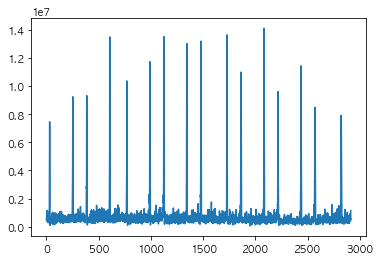

In [32]:
# Y값의 정규분포 띄지 않음..
all_time['target'].plot()

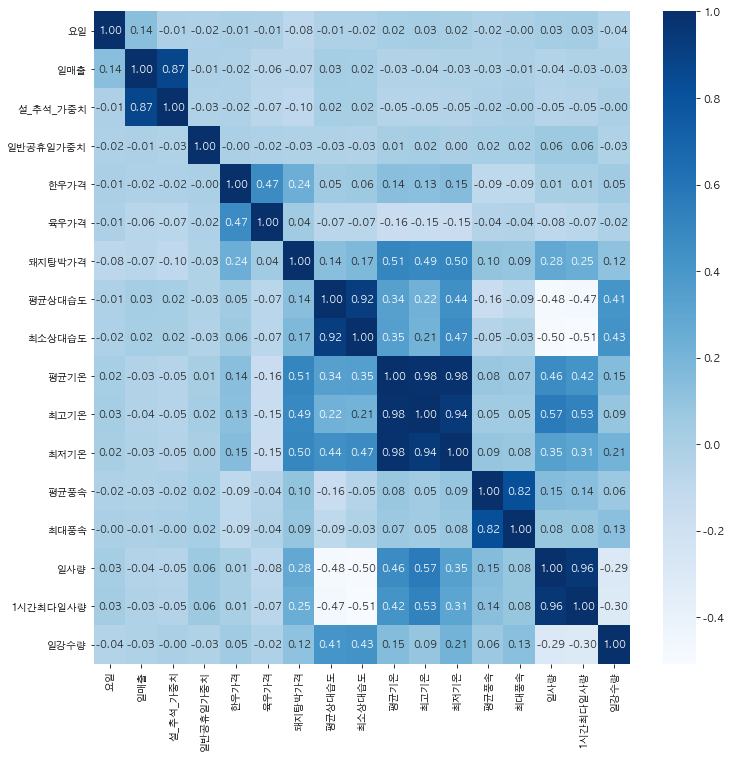

In [34]:
# 독립변수들 간의 다중공선성 살펴보기
import seaborn as sns
corr = all_time.iloc[:, 1:-1].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.2f')
plt.show()

In [35]:
# VIF요인 살펴보기
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

all_time = all_time.rename(columns={'1시간최다일사량':'최다일사량'})
x_columns = all_time.columns[1:-1].tolist()
x_columns.remove('일매출')

formula = '일매출 ~ ' + '+'.join(x_columns)

y, X = dmatrices(formula, all_time, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif

,VIF_Factor,Features
0,305.333739,Intercept
1,1.018355,요일
2,1.020120,설_추석_가중치
3,1.009876,일반공휴일가중치
4,1.442965,한우가격
5,1.383657,육우가격
6,1.478166,돼지탕박가격
7,7.894021,평균상대습도
8,10.071160,최소상대습도
9,405.238807,평균기온


- VIF요인이 7또는 10을 넘는 변수들 중 다음날 매출변수와 가장 상관관계가 높은 변수 1개를 빼고 나머지 제거
- 상대습도 중 1개 제외
- 기온 중 2개 제외
- 일사량 중 1개 제외
<br><br>
- 위 상관계수 행렬로 보아
    * 최소상대습도 제외
    * 최저기온, 평균기온 제외
    * 1시간최다일사량 제외

In [36]:
# 다중공선성 띄는 변수들 중 1개의 변수만 남기고 모두 제거(1개의 변수 판단 기준은 일매출과의 상관계수 기준으로)
multi_cols = ['최소상대습도', '최저기온', '평균기온', '최다일사량']
no_multi_time = all_time.drop(multi_cols, axis=1)
no_multi_time.columns

# set time index
no_multi_time['날짜'] = pd.to_datetime(no_multi_time['날짜'])
no_multi_time = no_multi_time.set_index('날짜')

MAE: 203125.781916
RMSE: 307186


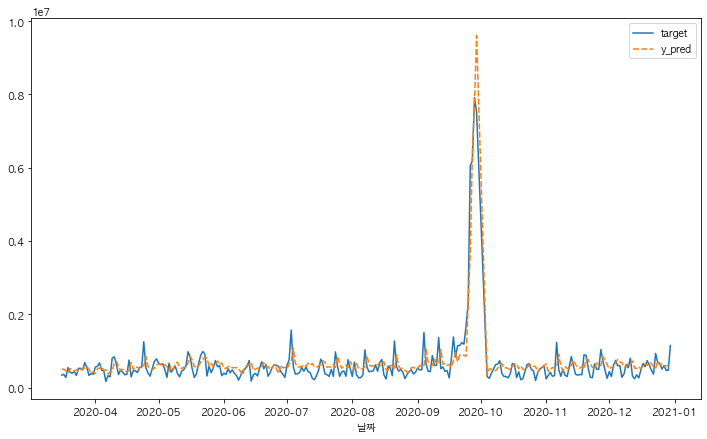

In [37]:
# 선형회귀 모델링
from sklearn.linear_model import LinearRegression
import math

splits = math.floor(no_multi_time.shape[0] * 0.9)
ftr_cols = no_multi_time.columns[:-1]
tgt_col = no_multi_time.columns[-1]
# split train, test
train = no_multi_time.iloc[:splits]
test = no_multi_time.iloc[splits:]
# split feature, target
X_train, y_train = train[ftr_cols], train[tgt_col]
X_test, y_test = test[ftr_cols], test[tgt_col]

# Modeling
lg_reg = LinearRegression()
lg_reg.fit(X_train, y_train)
# Predcit
y_train_pred = lg_reg.predict(X_train)
train['y_pred'] = y_train_pred
y_pred = lg_reg.predict(X_test)
test['y_pred'] = y_pred
# Evaluate
mae, rmse = get_metrics(y_test, y_pred)
print(f"MAE: {mae :0f}\nRMSE: {rmse :.0f}")

plt.figure(figsize=(12, 7))
sns.lineplot(data=test[['target', 'y_pred']], )
plt.show()

- Y값이 정규분포를 가정하고 있지 않기 때문에 예측 성능이 좋지 않다.

<AxesSubplot:xlabel='residual', ylabel='Density'>

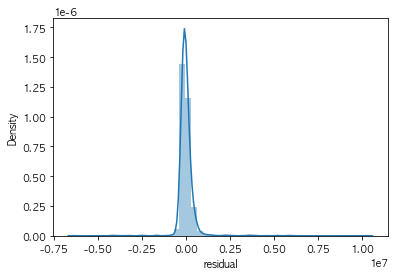

In [38]:
# 잔차 검정은 Train 데이터에 대한 잔차로 검정하자
# 잔차 정규성도 확인
train['residual'] = train['target'] - train['y_pred']
sns.distplot(train['residual'])

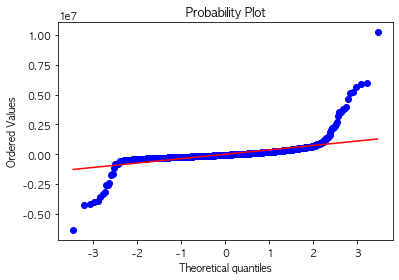

In [39]:
# QQ-plot for 잔차 정규성
import scipy.stats as stats

stats.probplot(train['residual'], plot=plt)
plt.show()

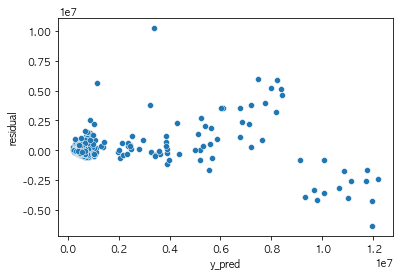

In [40]:
# 잔차 선형성, 등분산성, 독립성(for 시계열)
# X값은 Train에 대한 예측값, Y값은 잔차로 산점도 그리기
sns.scatterplot(data=train, x='y_pred', y='residual')
plt.show()

- 잔차 검정 결과, 선형회귀식의 적합이 잘 되지 않는 것으로 판단
- 해당 데이터는 비선형 함수를 사용하는 모델을 사용해야 하지 않을까 함..
    * 앙상블
    * 딥러닝 RNN

In [41]:
# X변수들 선택적 Scaling 후 재모델링
# 요일, 일매출, 설_추석_가중치, 일반공휴일 가중치, Target 변수 제외한 변수들 Scaling
no_scale_cols = ['요일', '일매출', '설_추석_가중치', '일반공휴일가중치', 'target']
scale_df = no_multi_time.drop(no_scale_cols, axis=1)

<AxesSubplot:>

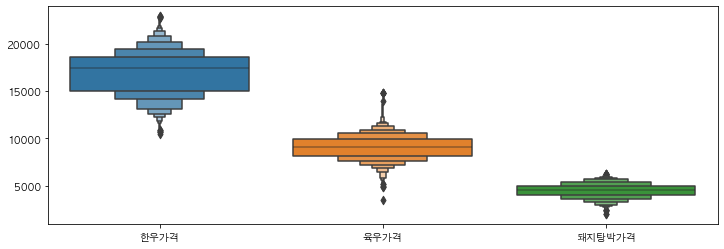

In [42]:
plt.figure(figsize=(12, 4))
sns.boxenplot(data=scale_df[['한우가격', '육우가격', '돼지탕박가격']])

<AxesSubplot:>

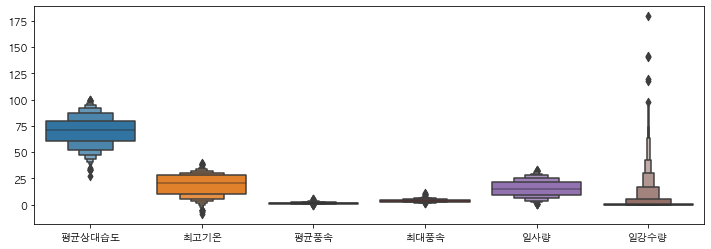

In [43]:
plt.figure(figsize=(12 ,4))
sns.boxenplot(data=scale_df[scale_df.columns[3:]])

- 강수량은 이상치가 있지만 이 이상치는 비온 날씨를 의미함. 하지만 상관계수로 보아 일강수량이 일매출에 영향을 미치는 것이 미미한 것으로 보아 이상치의 범위를 압축하는 것이 좋을 것이므로 ``MinMaxScaler``를 사용해 ``0~1``사이의 값으로 압축하자.

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_vals = scaler.fit_transform(scale_df)
scale_df = pd.DataFrame(scale_vals, columns=scale_df.columns)

In [45]:
# scaling한 변수들 병합
cols_order = no_multi_time.columns[:-1].tolist()
cols_order.append('target')
no_multi_scale_time = pd.concat([no_multi_time[no_scale_cols].reset_index(), scale_df], axis=1)
no_multi_scale_time['날짜'] = pd.to_datetime(no_multi_scale_time['날짜'])
no_multi_scale_time = no_multi_scale_time.set_index('날짜')
no_multi_scale_time = no_multi_scale_time[no_multi_time.columns]

In [66]:
# 스케일링한 데이터프레임 넣어야 함!
def evaluate_model(df, model):
    splits = math.floor(df.shape[0] * 0.9)
    ftr_cols = df.columns[1:-1]
    tgt_col = df.columns[-1]
    
    train = df.iloc[:splits]
    test = df.iloc[splits:]
    
    X_train, y_train = train[ftr_cols], train[tgt_col]
    X_test, y_test = test[ftr_cols], test[tgt_col]
    # Predict
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train['y_pred'] = y_train_pred
    test['y_pred'] = y_test_pred
    train['score'] = 0
    train.loc[abs(train['target']-train['y_pred']) < 1e5, 'score'] = 1
    test['score'] = 0
    test.loc[abs(test['target']-test['y_pred']) < 1e5, 'score'] = 1
    
    train_mae, _ = get_metrics(y_train, y_train_pred)
    train_acc = train['score'].mean() * 100
    test_mae, _ = get_metrics(y_test, y_test_pred)
    test_acc = test['score'].mean() * 100
    
    print(f"# Train MAE: {train_mae: .0f}\nTrain Accuracy: {train_acc: .2f}")
    print(f"# Test MAE: {test_mae: .0f}\nTest Accuracy: {test_acc :.2f}")
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=test[['target', 'y_pred']], )
    plt.show()

### Linear Regression

# Train MAE:  232864
Train Accuracy:  33.79
# Test MAE:  203094
Test Accuracy: 32.16


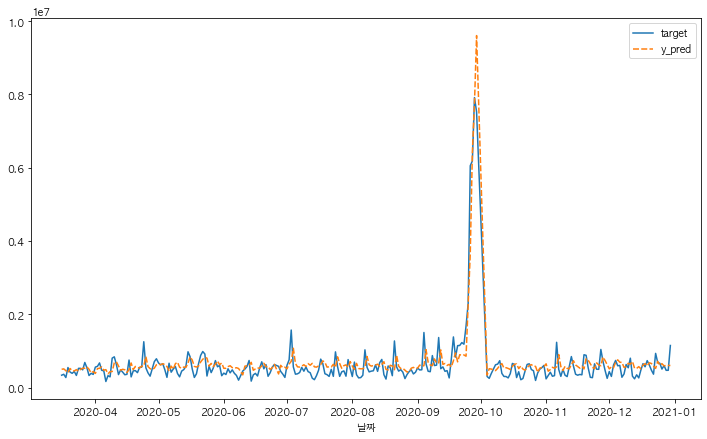

In [67]:
from sklearn.linear_model import LinearRegression

evaluate_model(no_multi_scale_time, LinearRegression())

- Scaling이 많은 예측 성능을 향상시키진 않는다.

### Polynomial Linear Regression

- 비선형 함수인 다항 회귀를 사용해보자

In [47]:
# Scaling된 변수들로 모델링
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

splits = math.floor(no_multi_scale_time.shape[0] * 0.9)
ftr_cols = no_multi_scale_time.columns[1:-1]
tgt_col = no_multi_scale_time.columns[-1]
# split train, test
train = no_multi_scale_time.iloc[:splits]
test = no_multi_scale_time.iloc[splits:]
# split feature, target
X_train, y_train = train[ftr_cols], train[tgt_col]
X_test, y_test = test[ftr_cols], test[tgt_col]

# 차수 범위를 설정해서 반복 모델링 하기 -> bias(절편값) 없애고 해보기
degrees = [i for i in range(2, 6)]
for degree in degrees:
    p_model = Pipeline([('poly', PolynomialFeatures(degree=degree,
                                                   include_bias=False)),
                       ('linear', LinearRegression())])
    # train
    p_model.fit(X_train, y_train)
    # Predict
    y_pred = p_model.predict(X_test)
    # Evaluate
    mae, rmse = get_metrics(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"# {degree}차항 다항회귀 MAE: {mae :.0f}원")
    print(f"# {degree}차항 다항회귀 RMSE: {rmse :.0f}원")
    print(f"# {degree}차항 다항회귀 결정계수: {r2}")
    print('-'*50)
    

# 2차항 다항회귀 MAE: 279290원
# 2차항 다항회귀 RMSE: 563444원
# 2차항 다항회귀 결정계수: 0.5104034102015672
--------------------------------------------------
# 3차항 다항회귀 MAE: 221333원
# 3차항 다항회귀 RMSE: 500725원
# 3차항 다항회귀 결정계수: 0.6133351938820846
--------------------------------------------------
# 4차항 다항회귀 MAE: 295751원
# 4차항 다항회귀 RMSE: 1063541원
# 4차항 다항회귀 결정계수: -0.7443939556745305
--------------------------------------------------
# 5차항 다항회귀 MAE: 267485원
# 5차항 다항회귀 RMSE: 625704원
# 5차항 다항회귀 결정계수: 0.3962264805931307
--------------------------------------------------


- 3차항 다항회귀가 가장 결정계수도 높고 MAE, RMSE값이 낮다..

### Random Forest Regressor

# Train MAE:  83773
Train Accuracy:  77.13
# Test MAE:  220287
Test Accuracy: 35.69


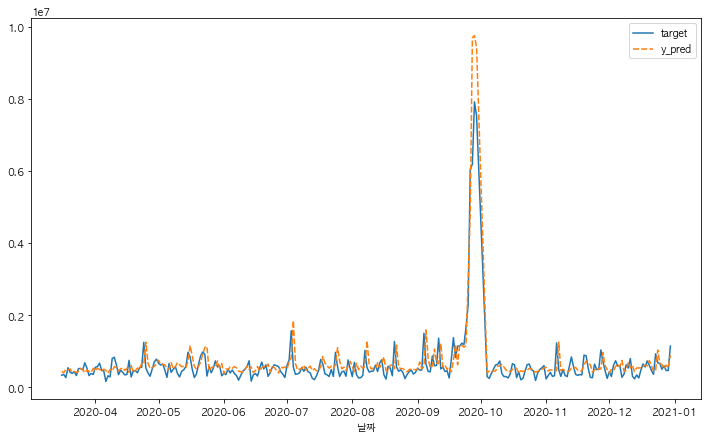

In [68]:
from sklearn.ensemble import RandomForestRegressor

evaluate_model(no_multi_scale_time, RandomForestRegressor())

In [49]:
# 요일별 데이터를 가져와서 랜덤포레스트 모델링하기
inverse_weekday_map = {v : k for k, v in weekday_map.items()}
no_multi_scale_time['요일'] = no_multi_scale_time['요일'].map(inverse_weekday_map)

# Friday 매출 예측 모델링
MAE: 257262.937500
RMSE: 331014
결정계수: 0.223


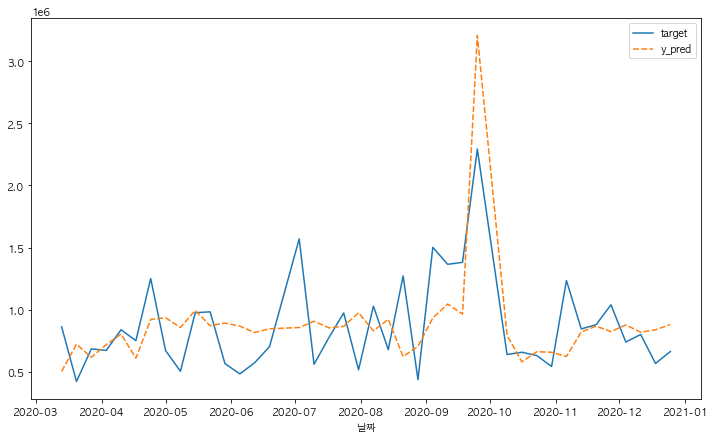

--------------------------------------------------
# Monday 매출 예측 모델링
MAE: 180927.682927
RMSE: 272478
결정계수: 0.946


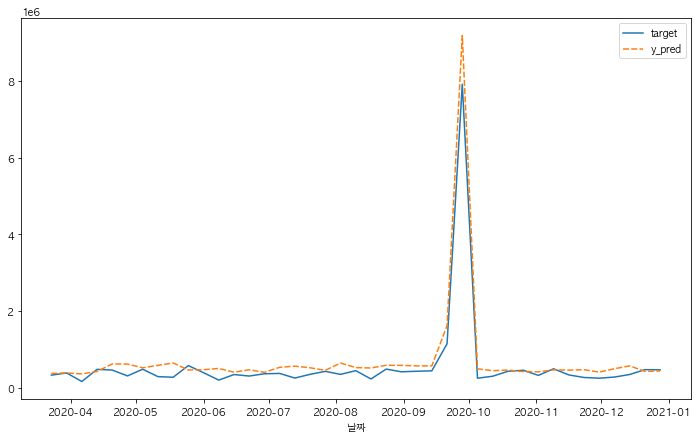

--------------------------------------------------
# Saturday 매출 예측 모델링
MAE: 242330.202500
RMSE: 508065
결정계수: 0.656


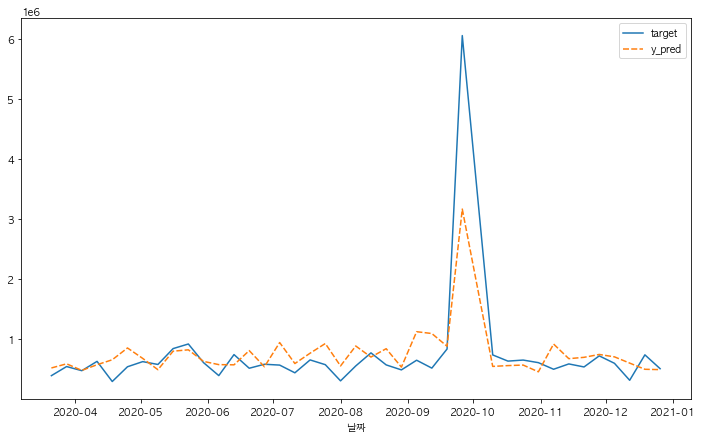

--------------------------------------------------
# Sunday 매출 예측 모델링
MAE: 172889.756098
RMSE: 385155
결정계수: 0.818


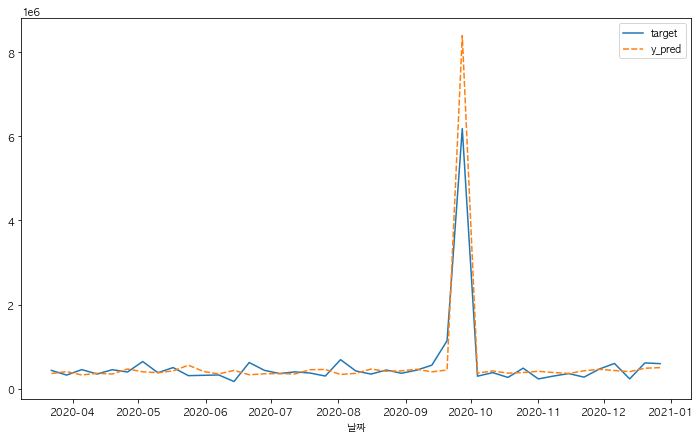

--------------------------------------------------
# Thursday 매출 예측 모델링
MAE: 167406.691707
RMSE: 200192
결정계수: 0.279


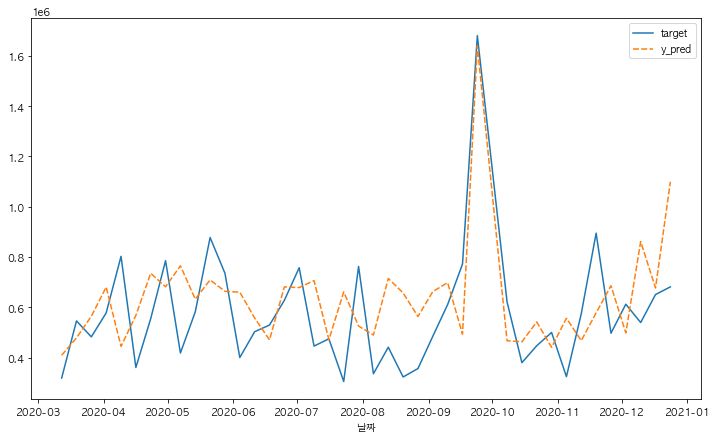

--------------------------------------------------
# Tuesday 매출 예측 모델링
MAE: 135812.682927
RMSE: 251572
결정계수: 0.949


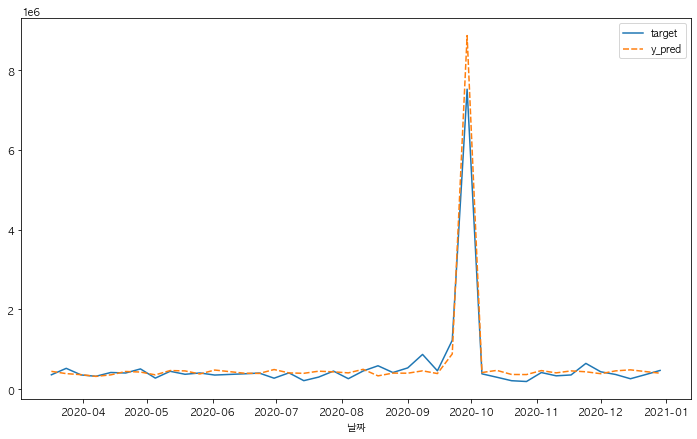

--------------------------------------------------
# Wednesday 매출 예측 모델링
MAE: 168288.243902
RMSE: 218881
결정계수: 0.003


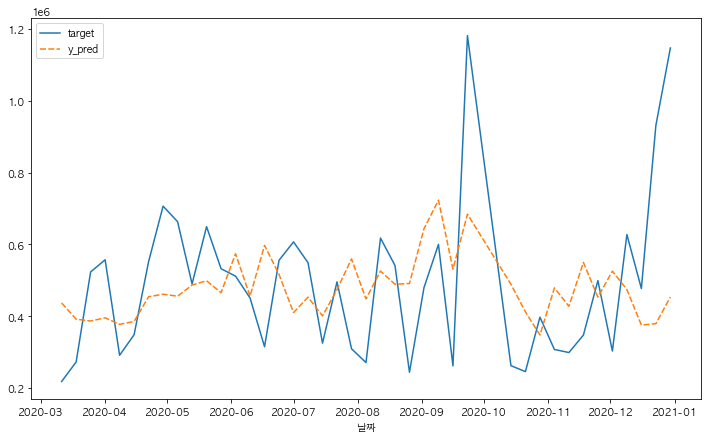

--------------------------------------------------


In [50]:
grouped = no_multi_scale_time.groupby('요일')
weekday_lst = list(grouped.groups.keys())
for i, g in enumerate(grouped.groups):
    group_df = grouped.get_group(g)
    # split train, test
    splits = math.floor(group_df.shape[0] * 0.9)
    train = group_df.iloc[:splits]
    test = group_df.iloc[splits:]
    # split feature, target
    ftr_cols = group_df.columns[1:-1]
    tgt_col = group_df.columns[-1]
    X_train, y_train = train[ftr_cols], train[tgt_col]
    X_test, y_test = test[ftr_cols], test[tgt_col]
    
    # Random Forest modeling
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train, y_train)
    # Predict, Evaluate
    y_pred = rf_reg.predict(X_test)
    test['y_pred'] = y_pred
    mae, rmse = get_metrics(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('#', weekday_lst[i], "매출 예측 모델링")
    print(f"MAE: {mae :0f}\nRMSE: {rmse :.0f}\n결정계수: {r2 :.3f}")
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=test[['target', 'y_pred']], )
    plt.show()
    print('-'*50)

- 한 번에 모델링 하는 것이 더 나을 것 같다..
    * 요일별로 MAE값이 상이함..
    * 더군다나 요일별로 하면 데이터가 매우 적어짐
    * 따라서 ``전체 시계열 데이터``를 최종 데이터셋으로 선정

### XGBoost Regressor

In [51]:
# 다시 요일에 가중치 부여한 칼럼으로 교체
no_multi_scale_time['요일'] = no_multi_scale_time['요일'].map(weekday_map)

[19:21:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Train MAE:  172083
Train Accuracy:  38.62
# Test MAE:  211394
Test Accuracy: 43.82


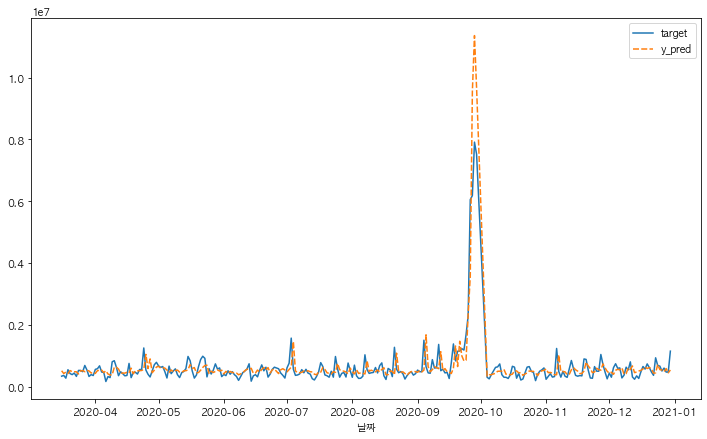

In [71]:
from xgboost import XGBRegressor

evaluate_model(no_multi_scale_time, XGBRegressor())

[19:21:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Train MAE:  214530
Train Accuracy:  32.93
# Test MAE:  200767
Test Accuracy: 37.10


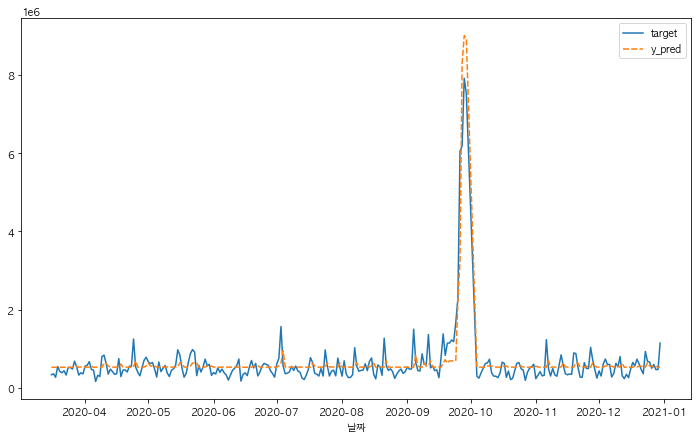

In [72]:
# Random Forest with XGBoost
from xgboost import XGBRFRegressor

evaluate_model(no_multi_scale_time, XGBRFRegressor())

- MAE값만 제일 낮지.. 그래프상으로 너무 스무딩됨..

### LightGBM

# Train MAE:  141734
Train Accuracy:  51.94
# Test MAE:  226139
Test Accuracy: 38.16


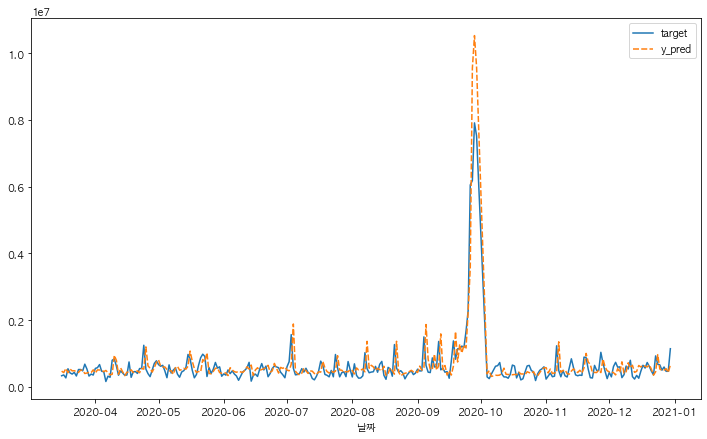

In [73]:
from lightgbm import LGBMRegressor

evaluate_model(no_multi_scale_time, LGBMRegressor())

- 현재 XGBoost가 10만원 미만의 오차로 맞춘 데이터가 48%로 가장 높은 예측 성능을 보이고 있음

### Hybrid Voting

[19:25:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Train MAE: 130943
# Train Accuracy: 51.71
# Test MAE: 180737
# Test Accuracy: 46.64


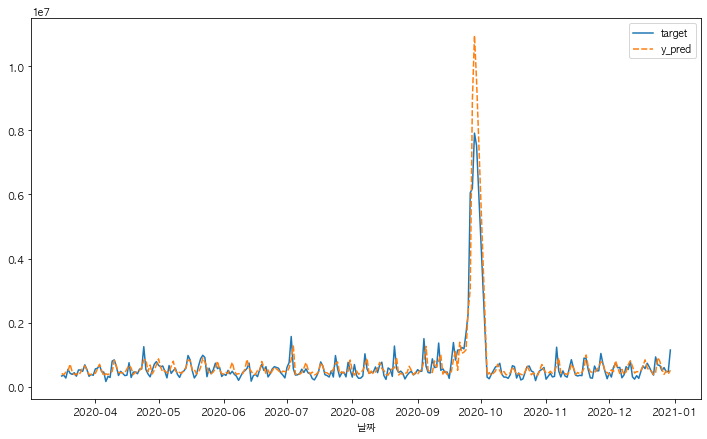

In [74]:
# Gradient Boosting 종류로 해보자! => 예측값에 대한 잔차를 계속 활용하기 때문!
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

splits = math.floor(no_multi_scale_time.shape[0] * 0.9)
ftr_cols = no_multi_scale_time.columns[:-1]
tgt_col = no_multi_scale_time.columns[-1]
# split train, test
train = no_multi_scale_time.iloc[:splits]
test = no_multi_scale_time.iloc[splits:]
# split feature, target
X_train, y_train = train[ftr_cols], train[tgt_col]
X_test, y_test = test[ftr_cols], test[tgt_col]

# Define hybrid voting
vote_model = VotingRegressor(estimators=[('xgb', XGBRegressor()),
                                        ('lgbm', LGBMRegressor()),
                                        ('gb', GradientBoostingRegressor())])
vote_model.fit(X_train, y_train)
# Predict, Evaluate
y_train_pred = vote_model.predict(X_train)
y_test_pred = vote_model.predict(X_test)
train['y_pred'] = y_train_pred
test['y_pred'] = y_test_pred
train['score'] = 0
train.loc[abs(train['y_pred']-train['target']) < 1e5, 'score'] = 1
test['score'] = 0
test.loc[abs(test['y_pred'] - test['target']) < 1e5, 'score'] = 1

train_mae, _ = get_metrics(y_train, y_train_pred)
train_acc = train['score'].mean() * 100
test_mae, _ = get_metrics(y_test, y_test_pred)
test_acc = test['score'].mean() * 100

print(f"# Train MAE: {train_mae :.0f}\n# Train Accuracy: {train_acc :.2f}")
print(f"# Test MAE: {test_mae :.0f}\n# Test Accuracy: {test_acc :.2f}")

plt.figure(figsize=(12, 7))
sns.lineplot(data=test[['target', 'y_pred']], )
plt.show()

### MLP Regressor

# Train MAE:  279039
Train Accuracy:  31.51
# Test MAE:  217203
Test Accuracy: 36.40


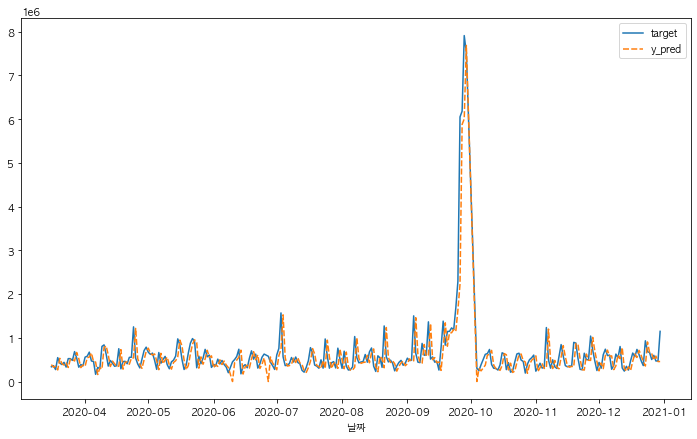

In [76]:
from sklearn.neural_network import MLPRegressor

evaluate_model(no_multi_scale_time, MLPRegressor())

### PLS Regression

In [ ]:
from sklearn.cross_decomposition import PLSRegression

n_comp = [n for n in range(1, no_multi_scale_time.shape[1]-1)]

for comp in n_comp:
    print(f"# 주성분 {comp}개수로 축소 후 PLS Regression 성능 지표")
    evaluate_model(no_multi_scale_time, PLSRegression(n_components=comp))

- 현재 **``Hybrid Voting``** 방식의 성능이 가장 좋음
    * 학습 데이터 중 50%, 테스트 데이터의 46%를 오차 10만원 미만으로 예측

### Feature Engineering

In [ ]:
# 파생변수 생성
# 나머지 변수들도 Scaling 해보기
# PCA(차원 축소)
# 